## Food Classification Algorithm using Tensorflow

## Name: Deepak Nayak

This approach is mainly focused on Feature Extraction technique where, I will be using InceptionV3 as base model.

## Here is the summary of the approach:

* Extracting the image folder from zip file
* Using pre-trained InceptionV3 model for transfer learning (as we have less data)
* Performing data augmentation rotation and horizontal flip just to add more non-linearity during training
* Loading InceptionV3 by removing the top layer of the model
* Training: Training by freezing the low-level layers (so that model can learn few features from new data)
* Added exponential learning rate decay functionality
* Also added dropout layer for the model and also early stopping during training to avoid over fitting of the model
* Saving the model file and weight files e

In [5]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from keras.layers import Input
from tensorflow.keras import models
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from keras.callbacks import LearningRateScheduler
import cv2

## InceptionV3
if include_top is False the input shape has to be (299, 299, 3) (with channels_last data format). It should have exactly 3 inputs channels, and width and height should be no smaller than 75.

In [14]:
K.clear_session()
n_classes = 6
img_width, img_height = 299, 299
train_data_dir = 'train/'
validation_data_dir = 'val/'
# nb_train_samples = 18750
# nb_validation_samples = 6250
batch_size = 32
dropout = 0.2
# learning_r = 0.0001
learning_r = 0.0
momentum = 0.9
epochs=40
verbose=1

def lr_exp_decay(epoch):
    initial_learning_rate = 0.01
    k = 0.01
    lrate=initial_learning_rate * math.exp(-k*epoch)
    return lrate
    
'''
ImageDataGenerator function is used to create any kind of data augmentation while training
'''
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[.8, 1],
    channel_shift_range=30,
    fill_mode='reflect')

test_datagen = ImageDataGenerator(rescale=1. / 255)

'''
flow_from_directory function takes data from the train/ test folder specified in the local disk
'''
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


def Inceptionv3_model(num_classes, dropout):
    '''
    This is the top layer of InceptionV3 (which we will not be using for our data)
    if we need full model summary, "InceptionV3("weights='imagenet', include_top=True).summary()""
    
    avg_pool (GlobalAveragePooling  (None, 2048)        0           ['mixed10[0][0]']                
     2D)                                                                                              
                                                                                                      
     predictions (Dense)            (None, 1000)         2049000     ['avg_pool[0][0]']               
    '''
    inception = InceptionV3(weights='imagenet', include_top=False)
    print("Total length of inception layers: ", len(inception.layers))
    for layer in inception.layers[:250]:
        layer.trainable = False 
    x = inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(dropout)(x)
    
    predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
    # predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
    
    model = Model(inputs=inception.input, outputs=predictions)
    return model

model = Inceptionv3_model(n_classes, dropout)

Found 396 images belonging to 6 classes.
Found 101 images belonging to 6 classes.
Total length of inception layers:  311


In [15]:
model.compile(optimizer=SGD(learning_rate=learning_r, momentum=momentum),
              loss='categorical_crossentropy',
              metrics=['accuracy','top_k_categorical_accuracy'])

# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy','top_k_categorical_accuracy'])


checkpoint_path = "training_inception/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)

# learning schedule callback
lrate = LearningRateScheduler(lr_exp_decay,verbose=1)
callbacks_list = [lrate, cp_callback, earlystopping]
# callbacks_list = [cp_callback, earlystopping]

# model.summary()
history_inception = model.fit(train_generator,
                    # steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    # validation_steps=nb_validation_samples // batch_size,
                    epochs=35,
                    callbacks=callbacks_list,
                    verbose=verbose)


Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/35


2023-08-16 21:27:12.083905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-08-16 21:27:17.389570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-16 21:27:21.819444: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-08-16 21:27:21.832461: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x3351cc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-16 21:27:21.832508: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2023-08-16 21:27:2

13/13 [==============================] - ETA: 0s - loss: 1.2584 - accuracy: 0.5480 - top_k_categorical_accuracy: 0.9394

2023-08-16 21:27:35.497386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: saving model to training_inception/cp.ckpt
13/13 [==============================] - 29s 1s/step - loss: 1.2584 - accuracy: 0.5480 - top_k_categorical_accuracy: 0.9394 - val_loss: 0.4155 - val_accuracy: 0.8812 - val_top_k_categorical_accuracy: 1.0000 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.009900498337491681.
Epoch 2/35
13/13 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.9116 - top_k_categorical_accuracy: 1.0000
Epoch 2: saving model to training_inception/cp.ckpt
13/13 [==============================] - 13s 983ms/step - loss: 0.3225 - accuracy: 0.9116 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2922 - val_accuracy: 0.9307 - val_top_k_categorical_accuracy: 1.0000 - lr: 0.0099

Epoch 3: LearningRateScheduler setting learning rate to 0.009801986733067553.
Epoch 3/35
13/13 [==============================] - ETA: 0s - loss: 0.1760 - accuracy: 0.9520 - top_k_categorical_accuracy: 1.0000
Epoch 3: saving model to trainin

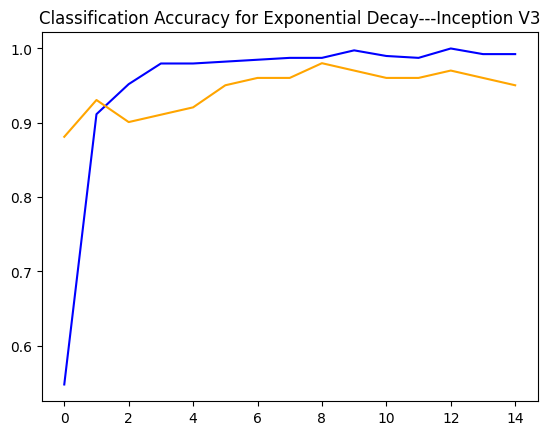

In [16]:
# Plotting the model accuracy
plt.title('Classification Accuracy for Exponential Decay---Inception V3')
plt.plot(history_inception.history['accuracy'], color='blue', label='train')
plt.plot(history_inception.history['val_accuracy'], color='orange', label='test')

## Testing the model with image

- 
In the below code just update the path variable. i.eimage_ path="yourimager_name"- 
Below code will output the predicted class label

In [ ]:
# To add the image that is to be tested
image_path = "/mnt/d/Deepak/Hyperhire/val/Pork/B070220XX_11049.jpg"


In [31]:
import keras.utils as image
import glob

shape = (299, 299, 3)

def load_inception_model(weights_path):
   model_final = Inceptionv3_model(n_classes, dropout)
   model_final.load_weights(weights_path)
   return model_final
    
def load_image(img_path, dimentions, rescale=1. / 255):
    img = image.load_img(img_path, target_size=dimentions)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x *= rescale # rescale the same as when trained
    return x

def get_classes(file_path):
    with open(file_path) as f:
        classes = f.read().splitlines()
    return classes

image = load_image(image_path, shape[:2])
trained_model = load_inception_model("training_inception/cp.ckpt")
preds = trained_model.predict(image)
classes = ['ApplePie', 'BagelSandwich', 'Bibimbop', 'Bread', 'FriedRice', 'Pork']
print("The image is: ", classes[np.argmax(preds)])

Total length of inception layers:  311
1/1 [==============================] - 1s 579ms/step
The image is:  Pork


# Below are the screenshots of training, accuracy and prediction of the mode

## ===================================================================
## Training of the model
## ===================================================================


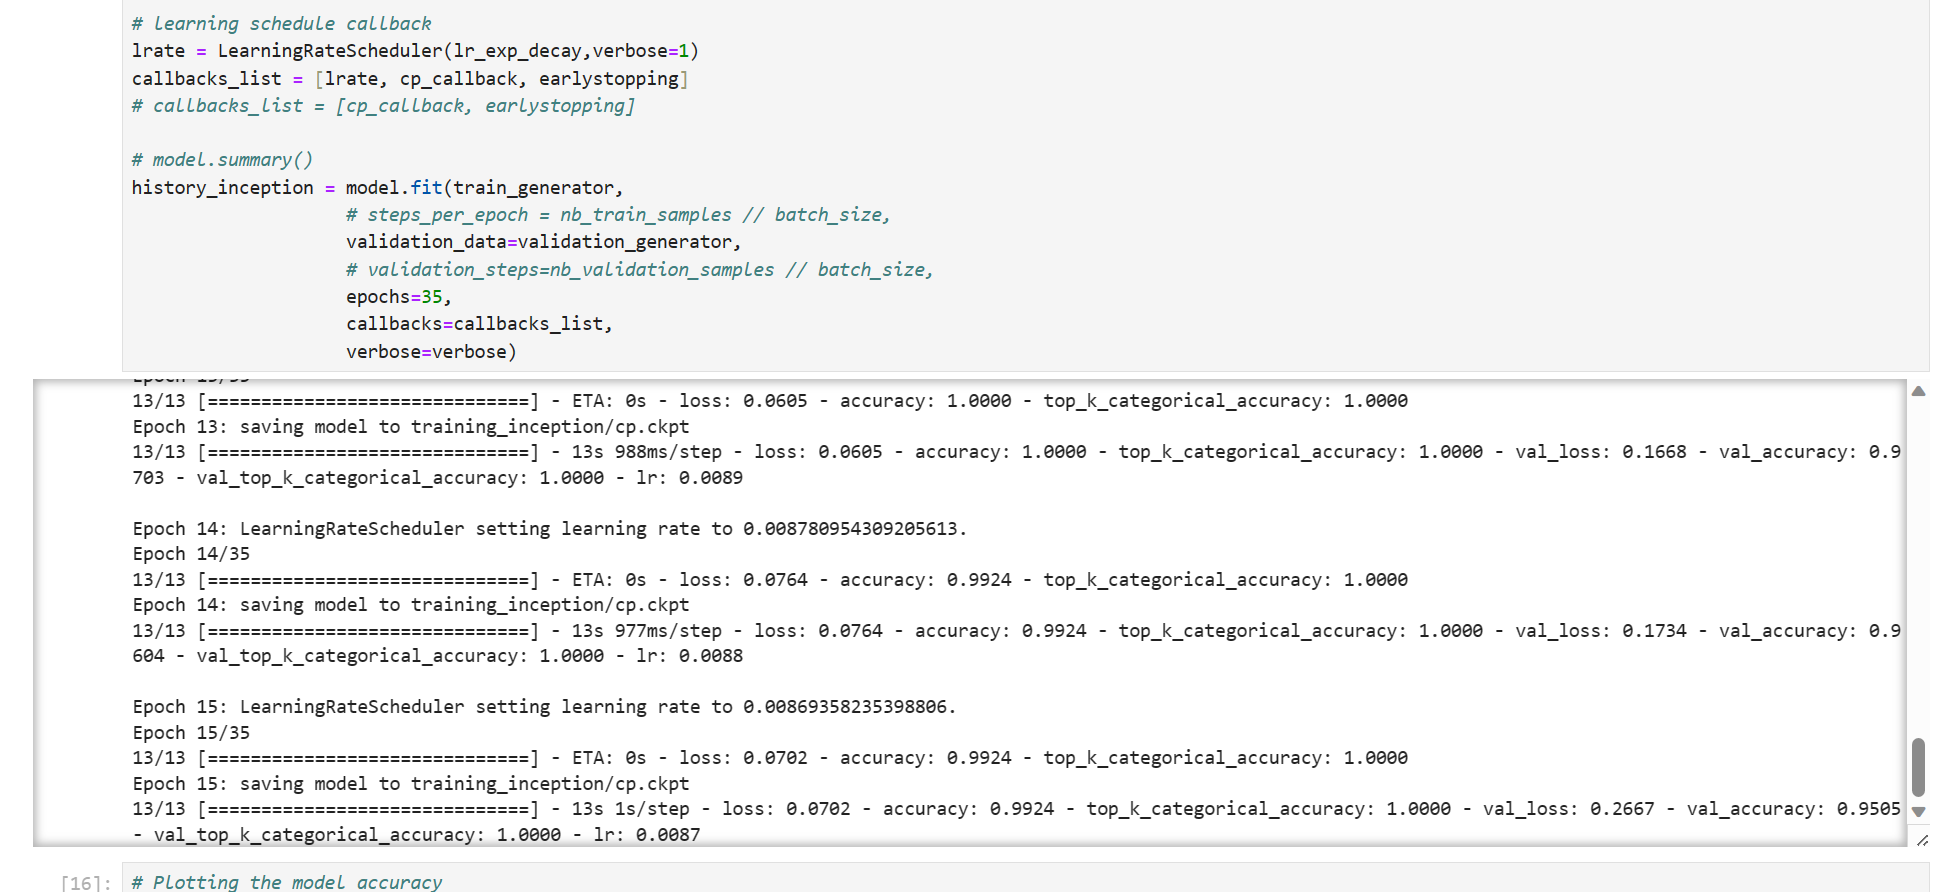

## ===================================================================
## Accuracy of the model
## ===================================================================


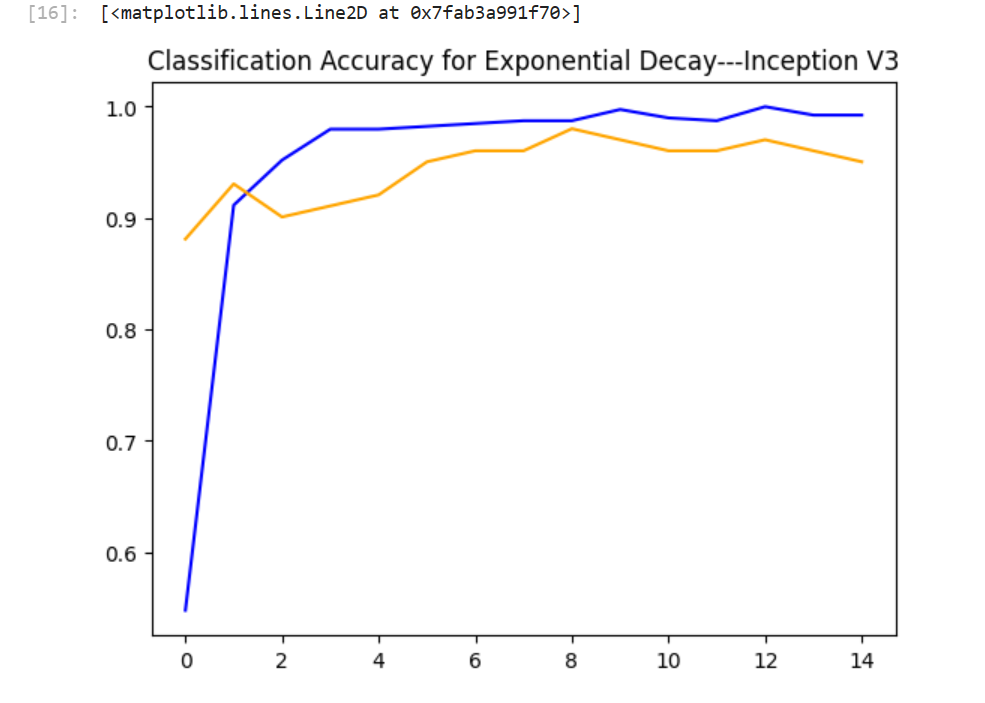

## ===================================================================
## Testing of the model
## ===================================================================


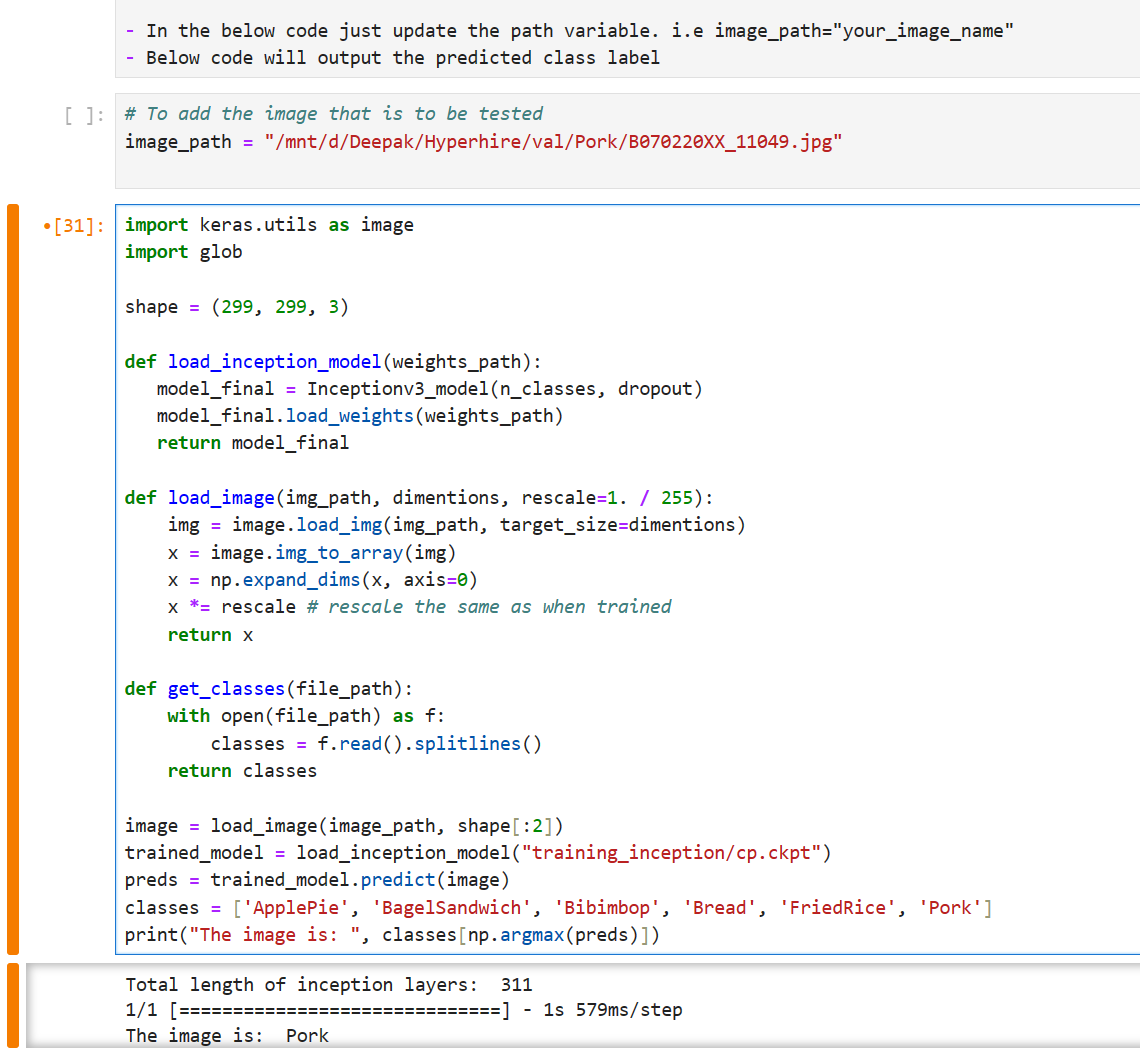